# Brain Tumor Classification - EfficientNet-B0 Training

This notebook trains an EfficientNet-B0 model using both the original and external datasets with enhanced augmentation and optimization techniques:

- **AdamW Optimizer** with differential learning rates
- **ReduceLROnPlateau Scheduler**
- **Label Smoothing**
- **Data Loader Optimizations** (num_workers, pin_memory)


In [ ]:
import os
import json
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms, models
from copy import deepcopy
import matplotlib.pyplot as plt
from custom_transforms import AddGaussianNoise

# M2 MacBook: Use MPS if available, else CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: MPS (Apple Silicon GPU)")
    pin_memory = False  # Not supported on MPS yet
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using device: CUDA")
    pin_memory = True
else:
    device = torch.device("cpu")
    print("Using device: CPU")
    pin_memory = False

print(f"PyTorch version: {torch.__version__}")


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


set_seed(42)
print("Seeds set to 42.")


Using device: MPS (Apple Silicon GPU)
PyTorch version: 2.8.0
Seeds set to 42.


In [2]:
from pathlib import Path

BASE_DIR = Path.cwd().resolve()
while not (BASE_DIR / "data").exists() and BASE_DIR.parent != BASE_DIR:
    BASE_DIR = BASE_DIR.parent

data_dir = BASE_DIR / "data" / "Brain_Tumor_Dataset" / "Training"
external_data_dir = (
    BASE_DIR / "data" / "Brain_Tumor_Dataset" / "external_dataset" / "training"
)


In [3]:
# Data Transforms
IMG_SIZE = 224

train_tf = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandAugment(
            num_ops=2, magnitude=9
        ),  # Standardized with ResNet18 & DenseNet
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_tf = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [4]:
# Load Datasets with proper split
print("Loading datasets...")
np.random.seed(42)  # Reproducibility!

# Load with train transforms (will be used for training)
dataset1 = datasets.ImageFolder(root=data_dir, transform=train_tf)

try:
    dataset2 = datasets.ImageFolder(root=external_data_dir, transform=train_tf)
    full_dataset = ConcatDataset([dataset1, dataset2])
    print("Combined dataset loaded.")
except Exception as e:
    print(f"Could not load external dataset: {e}")
    full_dataset = dataset1

class_names = dataset1.classes
print("Classes:", class_names)
print("Total samples:", len(full_dataset))

Loading datasets...
Combined dataset loaded.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Total samples: 14158


In [ ]:
# Create Data Loaders with proper train/val split
from torch.utils.data import Subset


def extract_targets(ds):
    if isinstance(ds, ConcatDataset):
        targets = []
        for sub in ds.datasets:
            targets.extend(extract_targets(sub))
        return targets
    if hasattr(ds, "targets"):
        return list(ds.targets)
    return [ds[i][1] for i in range(len(ds))]


def stratified_split(targets, val_frac=0.2, seed=42):
    rng = np.random.default_rng(seed)
    targets = np.array(targets)
    train_idx, val_idx = [], []
    for cls in np.unique(targets):
        cls_idx = np.where(targets == cls)[0]
        rng.shuffle(cls_idx)
        if len(cls_idx) == 1:
            split = 0
        else:
            split = max(1, int(np.floor(val_frac * len(cls_idx))))
        val_idx.extend(cls_idx[:split])
        train_idx.extend(cls_idx[split:])
    rng.shuffle(train_idx)
    rng.shuffle(val_idx)
    return train_idx, val_idx


targets = extract_targets(full_dataset)
train_idx, val_idx = stratified_split(targets, val_frac=0.2, seed=42)

# Create Subsets
train_subset = Subset(full_dataset, train_idx)

# For validation, we need to recreate with val_tf - create val dataset
dataset1_val = datasets.ImageFolder(root=data_dir, transform=val_tf)
try:
    dataset2_val = datasets.ImageFolder(root=external_data_dir, transform=val_tf)
    full_val_dataset = ConcatDataset([dataset1_val, dataset2_val])
except:
    full_val_dataset = dataset1_val

val_subset_proper = Subset(full_val_dataset, val_idx)

# Create DataLoaders
train_loader = DataLoader(
    train_subset,
    batch_size=32,
    shuffle=True,  # Shuffle the subset
    num_workers=2,
    pin_memory=pin_memory,
    drop_last=True,  # Important for BatchNorm stability
)
val_loader = DataLoader(
    val_subset_proper,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=pin_memory,
)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset_proper)}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Training samples: 11328
Validation samples: 2830
Training batches: 354
Validation batches: 89


In [6]:
# Model Setup - EfficientNet-B0
num_classes = len(class_names)

# Load EfficientNet-B0 with pretrained weights
base = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Modify classifier head
in_features = base.classifier[1].in_features
base.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # Stärkerer Dropout
    nn.Linear(in_features, num_classes),
)

# Unfreeze all layers for better fine-tuning (Differential Learning Rate will control updates)
for p in base.parameters():
    p.requires_grad = True

model = base.to(device)

# Optimizer: AdamW with Differential Learning Rates
# Lower LR for backbone (feature extractor), Higher LR for classifier (head)
params = [
    {
        "params": [p for n, p in model.named_parameters() if "classifier" not in n],
        "lr": 1e-5,
    },
    {"params": model.classifier.parameters(), "lr": 1e-3},
]
optimizer = optim.AdamW(params, weight_decay=1e-2)

# Scheduler: Reduce LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

# Loss with Label Smoothing to prevent overfitting
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

print("EfficientNet-B0 model ready for training on", device)

EfficientNet-B0 model ready for training on mps


In [7]:
# Training Loop
epochs = 30
patience = 7  # Increased patience because of scheduler
best_val = float("inf")
bad = 0
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

output_dir = "../runs"
model_dir = "../models"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

metrics_file = os.path.join(output_dir, "metrics_efficientnet.json")
model_save_path = os.path.join(model_dir, "brain_tumor_efficientnet_b0_trained.pt")

print("Starting training...")

for epoch in range(epochs):
    # --- Training ---
    model.train()
    tl, tc, tt = 0.0, 0, 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        tl += loss.item() * x.size(0)
        tc += (out.argmax(1) == y).sum().item()
        tt += y.size(0)

    train_loss = tl / tt
    train_acc = 100 * tc / tt

    # --- Validation ---
    model.eval()
    vl, vc, vt = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            vl += loss.item() * x.size(0)
            vc += (out.argmax(1) == y).sum().item()
            vt += y.size(0)

    val_loss = vl / vt
    val_acc = 100 * vc / vt

    # Scheduler Step
    scheduler.step(val_loss)

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch + 1:02d} | Train {train_loss:.4f}, Acc {train_acc:.2f}% | Val {val_loss:.4f}, Acc {val_acc:.2f}%"
    )

    # Early Stopping
    if val_loss < best_val:
        best_val = val_loss
        best_state = deepcopy(model.state_dict())
        torch.save(best_state, model_save_path)
        print(f"  → Model saved to {model_save_path}")
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

print("\nTraining complete!")

Starting training...
Epoch 01 | Train 0.7660, Acc 78.73% | Val 0.5688, Acc 90.07%
  → Model saved to ../models/brain_tumor_efficientnet_b0_trained.pt
Epoch 02 | Train 0.6103, Acc 87.78% | Val 0.5185, Acc 93.50%
  → Model saved to ../models/brain_tumor_efficientnet_b0_trained.pt
Epoch 03 | Train 0.5727, Acc 90.50% | Val 0.4871, Acc 94.24%
  → Model saved to ../models/brain_tumor_efficientnet_b0_trained.pt
Epoch 04 | Train 0.5456, Acc 91.53% | Val 0.4704, Acc 95.87%
  → Model saved to ../models/brain_tumor_efficientnet_b0_trained.pt
Epoch 05 | Train 0.5261, Acc 92.96% | Val 0.4546, Acc 96.43%
  → Model saved to ../models/brain_tumor_efficientnet_b0_trained.pt
Epoch 06 | Train 0.5096, Acc 93.66% | Val 0.4417, Acc 96.71%
  → Model saved to ../models/brain_tumor_efficientnet_b0_trained.pt
Epoch 07 | Train 0.4981, Acc 94.38% | Val 0.4347, Acc 96.64%
  → Model saved to ../models/brain_tumor_efficientnet_b0_trained.pt
Epoch 08 | Train 0.4870, Acc 94.75% | Val 0.4268, Acc 97.31%
  → Model saved

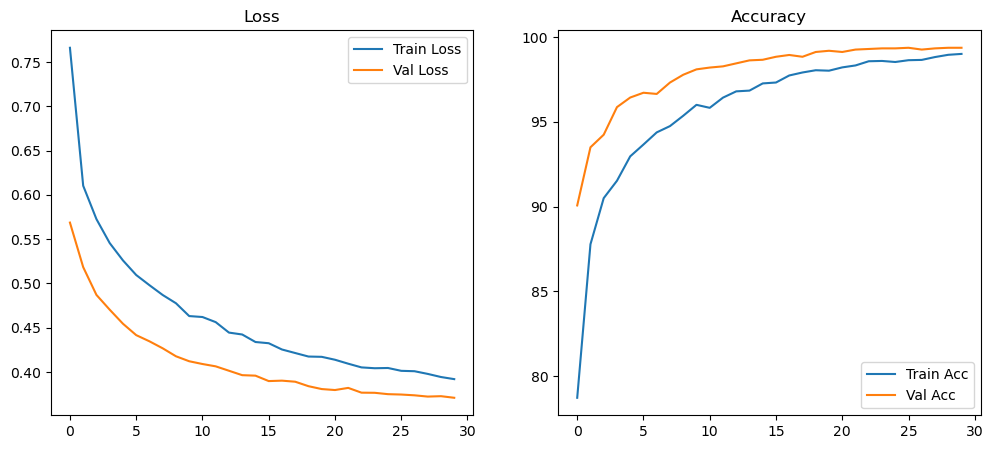

In [8]:
# Plot Results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend()
plt.title("Accuracy")
plt.show()

In [9]:
# Save metrics
with open(metrics_file, "w") as f:
    json.dump(history, f, indent=2)

print(f"Metrics saved to {metrics_file}")
print(f"Best validation loss: {best_val:.4f}")

Metrics saved to ../runs/metrics_efficientnet.json
Best validation loss: 0.3710
